In [9]:

import os
import pickle
import pprint

import matplotlib.pyplot as plt
import pandas as pd

import statistics

mapper_tests = {}


def get_objs_by_folder():
    directory = 'results'
    objs = []
    for root, subdirs, files in os.walk(directory):
        if root != 'results':
            tests_list = []
            for file in files:
                if file != '.DS_Store':
                    tests_list.append(file)
                    f = os.path.join(directory, str(root).split('/')[1] + '/' + file)
                    if os.path.isfile(f) and file.endswith('data'):
                        with open(f, 'rb') as filehandle:
                            # read the data as binary data stream
                            while 1:
                                try:
                                    objs.append(pickle.load(filehandle))
                                except EOFError:
                                    break
            mapper_tests[str(root).split('/')[1]] = tests_list
    return objs


# get_objs_by_folder()


def get_objs():
    directory = 'results'
    objs = []
    for k in mapper_tests.keys():
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename + '/' + k)
            if os.path.isfile(f) and filename.endswith('data'):
                with open(f, 'rb') as filehandle:
                    # read the data as binary data stream
                    while 1:
                        try:
                            objs.append(pickle.load(filehandle))
                        except EOFError:
                            break
        return objs

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcolors
from face_recognition.api import get_known_people_from_dataset


In [11]:
#TODO: get detection percentage out of every person

safe_mapper = {}
total_known_acc = 0


def generate_matrix_data(objs):
    unique_people = []
    people_list = []
    objs.sort(key=lambda x: x[0])
    for idx, results in enumerate(objs):
        if not results[0].startswith('stock'):
            people_list.append(results[0])

    unwanted_list = remove_unwanted_cols(people_list)
    lst = list(filter(lambda x: not x[0].startswith('stock'), objs))
    person_data = list(filter(lambda x: x[0] not in unwanted_list, lst))
    for data in person_data:
        unique_people.append(data[0])
    unique_people.append('unknown')
    size = len(lst)
    objs = lst
    matrix_data = np.zeros((size, len(unique_people)), dtype=np.float64)
    mapper = {'unknown': size}
    for idx, results in enumerate(objs):
        actual_name = results[0]
        mapper[actual_name] = idx

    for idx, results in enumerate(objs):
        actual_name = results[0]
        output_faces = results[1]
        global total_known_acc
        total_known_acc += results[2]
        if len(results) >= 4:
            safe_mapper[actual_name] = results[3]
        # print(actual_name, output_faces)

        for name, count in output_faces.items():
            if name in mapper.keys():
                X = 100 * count / sum(output_faces.values())
                # print(actual_name, name)
                # print(int(mapper[actual_name]), int(mapper[name]))
                index = unique_people.index(name)
                matrix_data[int(mapper[actual_name])][index] = X

    total_known_acc = total_known_acc / len(objs)
    return matrix_data, people_list, unique_people

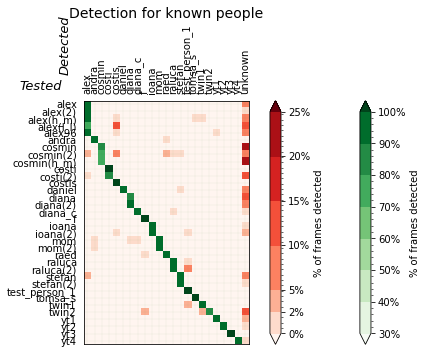

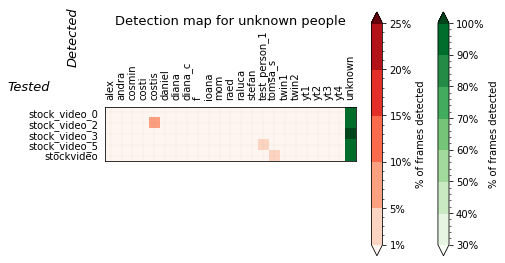

30-frame safe: (= no existing set of 30 consecutive frames detecting the wrong person)
{'alex': True,
 'alex(2)': True,
 'alex(h_m)': True,
 'alex(l_l)': True,
 'andra': True,
 'cosmin': True,
 'cosmin(h_m)': True,
 'costi': True,
 'costi(2)': True,
 'daniel': True,
 'diana': True,
 'diana(2)': True,
 'diana_c': True,
 'ioana': True,
 'ioana(2)': True,
 'mom': True,
 'mom(2)': True,
 'raed': True,
 'raluca': True,
 'raluca(2)': True,
 'stefan': True,
 'stefan(2)': True,
 'twin1': True,
 'twin2': True,
 'yt1': True,
 'yt2': True,
 'yt4': True}
None
{'stock_video_0': True,
 'stock_video_2': True,
 'stock_video_3': True,
 'stock_video_5': True,
 'stockvideo': True}
None
Average accuracy % over known people 93.58259728487646
Average accuracy % over unknown people 81.2196480171821
(34, 23)


In [12]:
stock_safe_mapper = {}
total_unknown_acc = 0


def generate_stock_matrix_data(objs, unique_people):
    stock_people_list = []
    objs.sort(key=lambda x: x[0])
    for idx, results in enumerate(objs):
        if results[0].startswith('stock'):
            if results[0] not in stock_people_list:
                stock_people_list.append(results[0])

    lst = list(filter(lambda x: x[0].startswith('stock'), objs))
    # print(lst)
    size = len(lst) - 1
    objs = lst
    stock_matrix_data = np.zeros((size, len(unique_people)), dtype=np.float64)
    mapper = {'unknown': size}
    for idx, results in enumerate(objs):
        actual_name = results[0]
        mapper[actual_name] = idx
    # print(objs)
    # print('mapper', mapper)
    for idx, results in enumerate(objs):
        actual_name = results[0]
        output_faces = results[1]
        global total_unknown_acc
        total_unknown_acc += results[2]
        if len(results) >= 4:
            stock_safe_mapper[actual_name] = results[3]
        # print(actual_name, output_faces)
        # print(output_faces)
        if type(output_faces) != str:
            for name, count in output_faces.items():
                X = 100 * count / sum(output_faces.values())
                # print(actual_name, name)
                # print(int(mapper[actual_name]), int(mapper[name]))
                index = unique_people.index(name)
                stock_matrix_data[int(mapper[actual_name]) - 1][index] = X
    total_unknown_acc = total_unknown_acc / len(objs)
    return stock_matrix_data, stock_people_list


def remove_unwanted_cols(people_list):
    unwanted_list = []
    dataset_people = get_known_people_from_dataset()
    for f in mapper_tests.values():
        for t in f:
            split = t.split('.data')[0]
            if split in people_list and split not in dataset_people:
                unwanted_list.append(split)
    return unwanted_list


pass

from numpy.ma import masked_array


def plot_matrix(arr, people_list):
    fig, ax = plt.subplots()
    ax.matshow(arr, cmap='Greens', interpolation='none')

    ax.set_xticks(list(range(len(unique_people))))
    ax.set_xticklabels(unique_people)

    ax.set_yticks(list(range(len(people_list))))
    ax.set_yticklabels(people_list)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    plt.title("Detection for known people", fontsize=14)
    fig.set_facecolor("white")

    bounds = [30, 40, 50, 60, 70, 80, 90, 100]
    bounds_reds = [0.1, 2.5, 5, 10, 15, 20, 25]

    cmap = mpl.cm.Greens
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

    cmap_reds = mpl.cm.Reds
    norm_reds = mpl.colors.BoundaryNorm(bounds_reds, cmap_reds.N, extend='both')

    greens = masked_array(arr, arr < 30)
    reds = masked_array(arr, arr >= 30)

    plt.xticks(rotation=90)

    pos_neg_clipped = ax.imshow(greens,
                                cmap="Greens",
                                interpolation='none',
                                norm=norm)

    pos_neg_clipped_reds = ax.imshow(reds,
                                     cmap="Reds",
                                     interpolation='none',
                                     norm=norm_reds)

    cbar = fig.colorbar(pos_neg_clipped,
                        format='%.0f%' + '%',
                        spacing='proportional',
                        extend='both',
                        label='% of frames detected')

    cbar_reds = fig.colorbar(pos_neg_clipped_reds,
                             format='%.0f%' + '%',
                             spacing='proportional',
                             extend='both',
                             label='% of frames detected')

    ax.text(-9.5, -2, r'Tested', style='italic', fontsize=13, weight='light')
    ax.text(-4, -4.5, r'Detected', style='italic', fontsize=13, rotation='vertical', weight='light')
    cbar.minorticks_on()
    cbar_reds.minorticks_on()

    plt.grid(color='g', linestyle='-.', linewidth=0.05)
    N = 55
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2  # inch margin
    s = maxsize / plt.gcf().dpi * N + 2 * m
    margin = m / plt.gcf().get_size_inches()[0]

    fig.subplots_adjust(bottom=margin, right=1. - margin)
    fig.set_size_inches(s, plt.gcf().get_size_inches()[1])
    plt.savefig('statistics_docs/Graph' + ".png")

    plt.show()


def plot_stock_matrix(arr, people_list):
    fig, ax = plt.subplots()
    ax.matshow(arr, cmap='Greens', interpolation='none')

    ax.set_xticks(list(range(len(unique_people))))
    ax.set_xticklabels(unique_people)

    ax.set_yticks(list(range(len(people_list))))
    ax.set_yticklabels(people_list)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    plt.title("Detection map for unknown people", fontsize=13)
    fig.set_facecolor("white")

    bounds = [30, 40, 50, 60, 70, 80, 90, 100]
    bounds_reds = [1, 5, 10, 15, 20, 25]

    cmap = mpl.cm.Greens
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

    cmap_reds = mpl.cm.Reds
    norm_reds = mpl.colors.BoundaryNorm(bounds_reds, cmap_reds.N, extend='both')

    greens = masked_array(arr, arr < 30)
    reds = masked_array(arr, arr >= 30)

    plt.xticks(rotation=90)

    pos_neg_clipped = ax.imshow(greens,
                                cmap="Greens",
                                interpolation='none',
                                norm=norm)

    pos_neg_clipped_reds = ax.imshow(reds,
                                     cmap="Reds",
                                     interpolation='none',
                                     norm=norm_reds)

    cbar = fig.colorbar(pos_neg_clipped,
                        format='%.0f%' + '%',
                        spacing='proportional',
                        extend='both',
                        label='% of frames detected')

    cbar_reds = fig.colorbar(pos_neg_clipped_reds,
                             format='%.0f%' + '%',
                             spacing='proportional',
                             extend='both',
                             label='% of frames detected')

    ax.text(-9.5, -2, r'Tested', style='italic', fontsize=13, weight='light')
    ax.text(-4, -4.5, r'Detected', style='italic', fontsize=13, rotation='vertical', weight='light')
    cbar.minorticks_on()
    cbar_reds.minorticks_on()

    plt.grid(color='g', linestyle='-.', linewidth=0.05)
    N = 40
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2  # inch margin
    s = maxsize / plt.gcf().dpi * N + 2 * m
    margin = m / plt.gcf().get_size_inches()[0]

    fig.subplots_adjust(bottom=margin, right=1. - margin)
    fig.set_size_inches(s, plt.gcf().get_size_inches()[1])
    plt.savefig('statistics_docs/Graph_unknown' + ".png")

    plt.show()


objs = get_objs_by_folder()
matrix_data, people_list, unique_people = generate_matrix_data(objs)

stock_matrix, unique_stock = generate_stock_matrix_data(objs, unique_people)
plot_matrix(matrix_data, people_list)
plot_stock_matrix(stock_matrix, unique_stock)

np.set_printoptions(precision=1)

print("30-frame safe: (= no existing set of 30 consecutive frames detecting the wrong person)")
print(pprint.pprint(safe_mapper))
print(pprint.pprint(stock_safe_mapper))
print('Average accuracy % over known people', total_known_acc)
print('Average accuracy % over unknown people', total_unknown_acc)

df = pd.DataFrame(data=safe_mapper, index=safe_mapper.keys())
df.to_csv(f'statistics_docs/safe_mapper.csv', index=True, header=True)

print(matrix_data.shape)

df = pd.DataFrame(data=np.round(matrix_data, 1), index=people_list, columns=unique_people)
df.to_csv(f"statistics_docs/Known people.csv", index=True, header=True)

df = pd.DataFrame(data=np.round(stock_matrix, 1), index=unique_stock, columns=unique_people)
df.to_csv(f"statistics_docs/Unknown people.csv", index=True, header=True)

(34, 23)


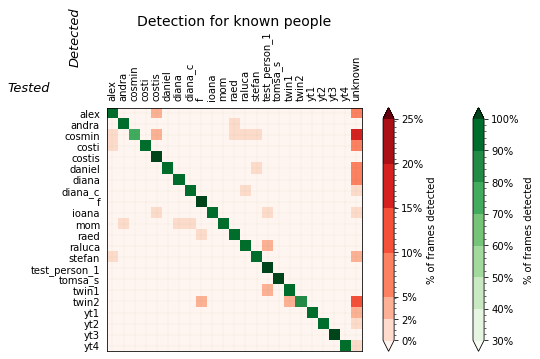

In [13]:
confusion_matrix = {}
compressed_matrix = []


def merge_row(mat, idx1, idx2):
    # print(sum(list(matrix[idx1][idx1:idx2])))
    for idx, col in enumerate(mat[idx1]):
        mat[idx1][idx] = sum(list(mat[idx1:idx2, idx])) / (idx2 - idx1)
    for idx in range(idx1 + 1, idx2):
        mat = np.delete(mat, idx1 + 1, 0)
        people_list.pop(idx1 + 1)
    return mat
    pass


for k, v in mapper_tests.items():
    for idx, value in enumerate(v):
        mapper_tests[k].append(mapper_tests[k][idx].split('.data')[0])
        mapper_tests[k].pop(idx)

print(matrix_data.shape)

matrix_data = merge_row(matrix_data, 0, 5)
matrix_data = merge_row(matrix_data, 2, 5)
matrix_data = merge_row(matrix_data, 3, 5)
matrix_data = merge_row(matrix_data, 6, 8)
matrix_data = merge_row(matrix_data, 9, 11)
matrix_data = merge_row(matrix_data, 10, 12)
matrix_data = merge_row(matrix_data, 12, 14)
matrix_data = merge_row(matrix_data, 13, 15)

plot_matrix(matrix_data, people_list)

df = pd.DataFrame(data=np.round(matrix_data, 1), index=people_list, columns=unique_people)
df.to_csv(f"statistics_docs/Known people(compressed).csv", index=True, header=True)

In [14]:

acc_mapper = []
perc_stats = {}
for i in range(len(matrix_data)):
    acc_mapper.append(matrix_data[i, i])

acc_mapper.append(0)
P = len(people_list)
N = len(people_list) + 1

FPR = matrix_data.sum(axis=0)
FPR = [x - acc_mapper[idx] for idx, x in enumerate(FPR)]
FNR = matrix_data.sum(axis=1)
FNR = [x - acc_mapper[idx] for idx, x in enumerate(FNR)]
FPR = np.average(FPR)
FNR = np.average(FNR)
TPR = 100 - FNR
TNR = 100 - round(FPR, 2)
print(f'FPR: {round(FPR, 2)} %')
print(f'TNR: {TNR} %')
print(f'FNR: {round(FNR, 2)} %')
print('TPR:', round(np.average([matrix_data[i, i] for i in range(len(matrix_data))]), 2), '%')

ACC = (TPR + TNR) / 2
print('Acuracy:', ACC)
PRECISION = (TPR / (TPR + FPR)) * 100
print('Precision:', PRECISION, '%')

perc_stats["FPR"] = FPR
perc_stats["TNR"] = TNR
perc_stats["FNR"] = FNR
perc_stats["TPR"] = TPR
perc_stats["Acuracy"] = ACC
perc_stats["Precision"] = PRECISION

df = pd.DataFrame(data=perc_stats, index=perc_stats.keys())
df.to_csv(f'statistics_docs/perc_stats.csv', index=True, header=True)

plt.show()

FPR: 4.41 %
TNR: 95.59 %
FNR: 4.61 %
TPR: 95.39 %
Acuracy: 95.49059884887711
Precision: 95.58272895918117 %


In [15]:
from statistics import stdev

def listRightIndex(alist, value):
    return len(alist) - alist[-1::-1].index(value) - 1


def get_full_path(filename):
    path = (os.path.expanduser('~/Documents/GitHub/Licenta'))
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in [f for f in filenames if f.endswith(filename)]:
            return os.path.join(dirpath, filename)
    return None


path_counter = get_full_path('encodings_counter.data')
with open(path_counter, 'rb') as filehandle:
    counter = pickle.load(filehandle)

names = []
for k, v in counter.items():
    names.append(k)

known_face_names = []
for name in names:
    for j in range(counter[name]):
        known_face_names.append(name)

path = get_full_path('face_encodings.data')
with open(path, 'rb') as filehandle:
    known_face_encodings = pickle.load(filehandle)

arrs = []
for idx, encoding in enumerate(known_face_encodings[:-1]):
    arrs.append(np.linalg.norm(known_face_encodings[idx]))

    if known_face_names[idx] != known_face_names[idx + 1]:
        std_ = stdev(arrs)
        print(std_, known_face_names[idx])
        arrs = []

0.025282569455257177 Stefan
0.020388294016916376 yt4
0.007223087852089675 diana_c
0.005836024087884045 diana
0.019209037088932204 f
0.020616164562448122 tomsa_s
0.03922668809285001 costis
0.021043823345697855 Raluca
0.013819753011258467 cosmin
0.044721506349565336 yt2
0.029430714562079893 costi
0.030763321617640445 alex
0.021168213748041002 yt3
0.02802779830801699 test_person_1
0.008967853470551825 twin2
0.002504367191026698 daniel
0.011884536731281035 twin1
0.03961321446192555 yt1
0.03152975631099774 Mom
0.035481195913555794 ioana
0.028425346238999446 andra


## Scatter plot

In [16]:
import altair as alt
import pandas as pd

map_arr = []
maps_list = {}  # assigns each encoding to individuals
queue = []
for i, (k, v) in enumerate(counter.items()):
    temp = []
    queue.append(v)
    if len(queue) < 2:
        for idx in range(0, v):
            temp.append(np.linalg.norm(known_face_encodings[idx]))
    else:
        for idx in range(sum(queue) - v, sum(queue)):
            temp.append(np.linalg.norm(known_face_encodings[idx]))
    maps_list[k] = temp

print(len(list(maps_list.values())[1]))
names = list(maps_list.keys())
print(names)
x = []
stats = {}
for idx in range(len(list(maps_list.values()))):
    val = list(maps_list.values())[idx]
    x += val
    stats[names[idx]] = (
        round(*[statistics.stdev(val) * 100], 5),
        round(statistics.median(val), 5),
        round(np.min(val), 5),
        round(np.average(val), 5),
        round(np.max(val), 5)
    )

stats = pd.DataFrame(stats, index=['STDev', 'Median', 'Min', 'Avg', 'Max'])
brush = alt.selection(type='interval', resolve='global')
stats.to_csv(f"statistics_docs/Norm statistics.csv", index=True, header=True)

print(stats)

data = pd.DataFrame(
    {
        'Norm of every face in the DB': x,
        'Names': known_face_names
    }
)
data.to_csv(f"statistics_docs/encodings.csv", index=True, header=True)

alt.data_transformers.disable_max_rows()

brush = alt.selection(type='interval', resolve='global')

chart2 = alt.Chart(data).mark_point().encode(
    alt.X('Norm of every face in the DB',
          title='Norm',
          scale=alt.Scale(domain=[1.2, 1.58])
          ),
    alt.Y('Names')
).add_selection(
    brush
).properties(
    width=700, height=450
)





600
['Stefan', 'yt4', 'diana_c', 'diana', 'f', 'tomsa_s', 'costis', 'Raluca', 'cosmin', 'yt2', 'costi', 'alex', 'yt3', 'test_person_1', 'twin2', 'daniel', 'twin1', 'yt1', 'Mom', 'ioana', 'andra', 'raed']
         Stefan      yt4  diana_c    diana        f  tomsa_s   costis  \
STDev   2.52826  2.03883  0.72231  0.58360  1.92090  2.06162  3.92267   
Median  1.40149  1.36917  1.52424  1.44173  1.38206  1.28992  1.35017   
Min     1.28818  1.30311  1.49247  1.32777  1.30241  1.24614  1.26248   
Avg     1.40188  1.36871  1.52182  1.44128  1.38319  1.29329  1.35389   
Max     1.48853  1.42793  1.52833  1.45339  1.43123  1.40448  1.47809   

         Raluca   cosmin      yt2  ...      yt3  test_person_1    twin2  \
STDev   2.10438  1.38198  4.47215  ...  2.11682        2.80278  0.89679   
Median  1.42490  1.31917  1.43755  ...  1.40216        1.34313  1.34110   
Min     1.35829  1.28851  1.22015  ...  1.31395        1.26367  1.30721   
Avg     1.42448  1.32364  1.43496  ...  1.39900        1.